In [1]:
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')

2023-07-25 11:26:05.869455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 11:26:06.323747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
import h5py
with h5py.File("/home/danielaguirre/Documents/university/masteringml/MML-project/data/processed_data.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

imgs_train2 = []
imgs_test2 = []
for img in imgs_train:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
for img in imgs_test:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_test2.append(new_img)
imgs_train = np.array(imgs_train2)[:, :, :, np.newaxis] / 255
imgs_test = np.array(imgs_test2)[:, :, :, np.newaxis] / 255

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/danielaguirre/Documents/university/masteringml/MML-project/data/processed_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

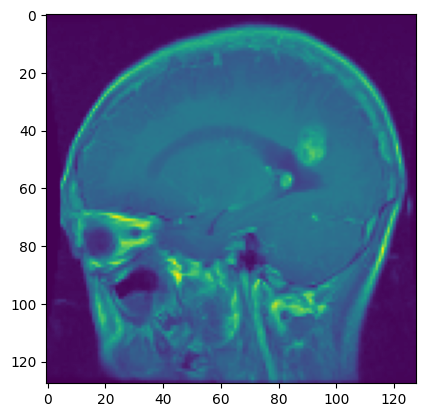

In [3]:
plt.imshow(imgs_train[0])

In [38]:
batch_size = 64 # batch size
latent_dim = 256 # latent space size
optim = Adam(lr=1e-3)
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
n_epoch = 100

In [9]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

def conv_block_transpose(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

### Encoder

In [13]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
enc_conv = conv_block(enc_input_image, filters=64, use_bn=True) # 128x128x64
enc_conv = conv_block(enc_conv, filters=64, strides=(2,2), use_bn=True, use_dropout=True) # 64x64x64

enc_conv = conv_block(enc_conv, filters=128, use_bn=True) # 64x64x128
enc_conv = conv_block(enc_conv, filters=128, strides=(2,2), use_bn=True, use_dropout=True) # 32x32x128

enc_conv = conv_block(enc_conv, filters=256, use_bn=True) # 32x32x256
#enc_conv = conv_block(enc_conv, filters=256, use_bn=True, use_dropout=True) # 32x32x256
#enc_conv = conv_block(enc_conv, filters=256, use_bn=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True) # 16x16x256

enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 16x16x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 16x16x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 8x8x512

enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 8x8x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 8x8x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 4x4x512


# concat
flattened = Flatten()(enc_conv)
enc_concat = Concatenate()([flattened, enc_input_label])


enc_hidden = Dense(4096)(enc_concat)
#enc_hidden = Dropout(0.3)(enc_hidden)
#enc_hidden = Dense(4096)(enc_hidden)
enc_hidden = Dropout(0.3)(enc_hidden)
enc_hidden = Dense(1024)(enc_hidden)
mu = Dense(latent_dim, activation='linear', name="mu")(enc_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(enc_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

encoder = Model([enc_input_image, enc_input_label], z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 128, 128, 64)         640       ['input_image[0][0]']         
                                                                                                  
 batch_normalization_52 (Ba  (None, 128, 128, 64)         256       ['conv2d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   multiple                     0         ['batch_normalization_52

                                                                                                  
 dropout_38 (Dropout)        (None, 4, 4, 512)            0         ['leaky_re_lu_2[35][0]']      
                                                                                                  
 flatten_4 (Flatten)         (None, 8192)                 0         ['dropout_38[0][0]']          
                                                                                                  
 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 8196)                 0         ['flatten_4[0][0]',           
 )                                                                   'input_label[0][0]']         
                                                                                                  
 dense_11 

### Decoder

In [14]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

dec_hidden = Dense(1024, activation="relu")(dec_concat)
dec_hidden = Dropout(0.3)(dec_hidden)
#dec_hidden = Dense(4096, activation="relu")(dec_hidden)
#dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(4096, activation="relu")(dec_hidden)
dec_hidden = Dense(4*4*512, activation="relu", name="hidden_layer7")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
reshaped = Reshape(target_shape=(4,4,512))(dec_hidden)

dec_conv = conv_block_transpose(reshaped, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 4x4x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True)  # 8x8x512

dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 8x8x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True)  # 16x16x512

dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
#dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True, use_dropout=True)  # 16x16x256
#dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True)  # 32x32x256

dec_conv = conv_block_transpose(dec_conv, filters=128, use_bn=True, use_dropout=True)  # 32x32x128
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 64x64x128

dec_conv = conv_block_transpose(dec_conv, filters=64, use_bn=True, use_dropout=True)  # 64x64x64
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 128x128x64

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_conv)
dec_output_img = Flatten()(dec_output_img)
decoder = Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 256)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 decoder_concat (Concatenat  (None, 260)                  0         ['input_latent_vector[0][0]', 
 e)                                                                  'input_label[0][0]']         
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 dropout_44 (Dropout)        (None, 32, 32, 256)          0         ['leaky_re_lu_3[15][0]']      
                                                                                                  
 conv2d_transpose_17 (Conv2  (None, 32, 32, 128)          295040    ['dropout_44[0][0]']          
 DTranspose)                                                                                      
                                                                                                  
 batch_normalization_68 (Ba  (None, 32, 32, 128)          512       ['conv2d_transpose_17[0][0]'] 
 tchNormalization)                                                                                
                                                                                                  
 dropout_4

### Conditional Variational autoencoder

In [15]:
latent_vector = encoder(inputs=[enc_input_image, enc_input_label]) # z
output_img = decoder(inputs=[latent_vector, enc_input_label])
CVAE = Model(inputs=[enc_input_image, enc_input_label], outputs=output_img, name="CVAE")
CVAE.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 encoder (Functional)        (None, 256)                  4771065   ['input_image[0][0]',         
                                                          6          'input_label[0][0]']         
                                                                                                  
 decoder (Functional)        (None, 16384)                4984096   ['encoder[0][0]',          

## Entrenamiento

In [16]:
def vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred): # it doesnt use y_true and y_pred but the parameters are necessary for compiling
     # importante se usan las capas de mu y sigma del encoder
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [34]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])

In [18]:
# the output of the decoder is a flattened img, 
# so we need to flatten the true values (input images from (28,28,1) => 784)
y_train = imgs_train.reshape(imgs_train.shape[0], -1)
y_test = imgs_test.reshape(imgs_test.shape[0], -1)
print(y_train.shape)

(2937, 16384)


In [39]:
checkpoint_filepath = 'model_checkpoints/checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True)

cvae_hist = CVAE.fit([imgs_train2, labels_train], y_train/255, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = ([imgs_test2, labels_test], y_test/255),
                    callbacks=[model_checkpoint_callback])

Train on 2937 samples, validate on 327 samples
Epoch 1/100
1024/2937 [=========>....................] - ETA: 7s - loss: nan - KL_loss: nan - recon_loss: nan

KeyboardInterrupt: 

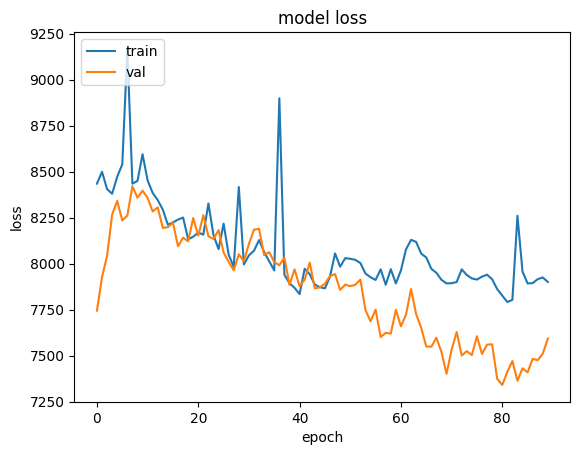

In [32]:
plt.plot(cvae_hist.history['loss'][10:])
plt.plot(cvae_hist.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

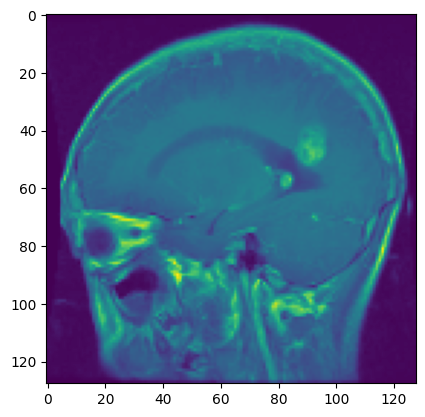

In [43]:
plt.imshow(imgs_train2[0])

## Prediccion

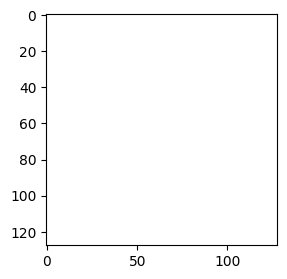

In [41]:
z = np.zeros(shape=(1, latent_dim))  # latent vector
z = np.random.normal(size=(1, latent_dim))
label = np.array([[0, 1, 0, 0]])  # label in one hot encoding
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict([z, label]).reshape(128, 128), cmap=plt.cm.gray)
plt.show()

In [26]:
latent_dim

256